# Lecture 14 Pre-trained CNNs with Keras

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
LECTURE_ID = "12"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", LECTURE_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. CNNs can be very slow without a GPU.


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense

A couple utility functions to plot grayscale and RGB images:

In [4]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [5]:
def crop(images):
    return images[150:220, 130:250]

## ResNet-34

In [6]:
from functools import partial

import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [38]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_4 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       

## Using a Pretrained Model

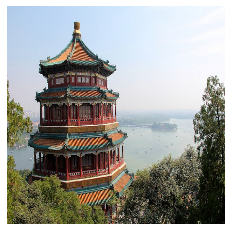

In [40]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

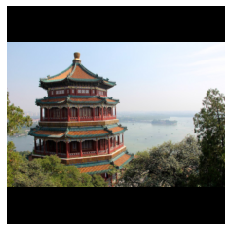

In [41]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

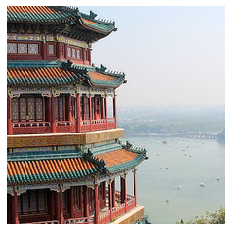

In [42]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

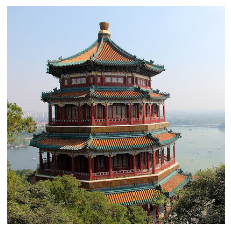

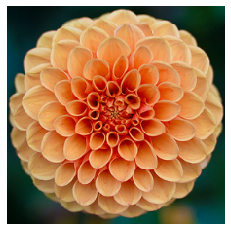

In [43]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [44]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [45]:
Y_proba.shape

(2, 10)

In [46]:

Top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)

for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
         print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (2, 10)

## Pretrained Models for Transfer Learning

In [2]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

In [ ]:
info.splits

In [ ]:
info.splits["train"]

In [ ]:
class_names = info.features["label"].names
class_names

In [ ]:
n_classes = info.features["label"].num_classes

In [ ]:
dataset_size = info.splits["train"].num_examples
dataset_size

**Warning:** TFDS's split API has evolved since the book was published. The [new split API](https://www.tensorflow.org/datasets/splits) (called S3) is much simpler to use:

In [ ]:
if not tf.config.list_physical_devices('GPU'):
    test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)
else:
    test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

Basic preprocessing:

In [47]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

Slightly fancier preprocessing (but you could add much more data augmentation):

In [48]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

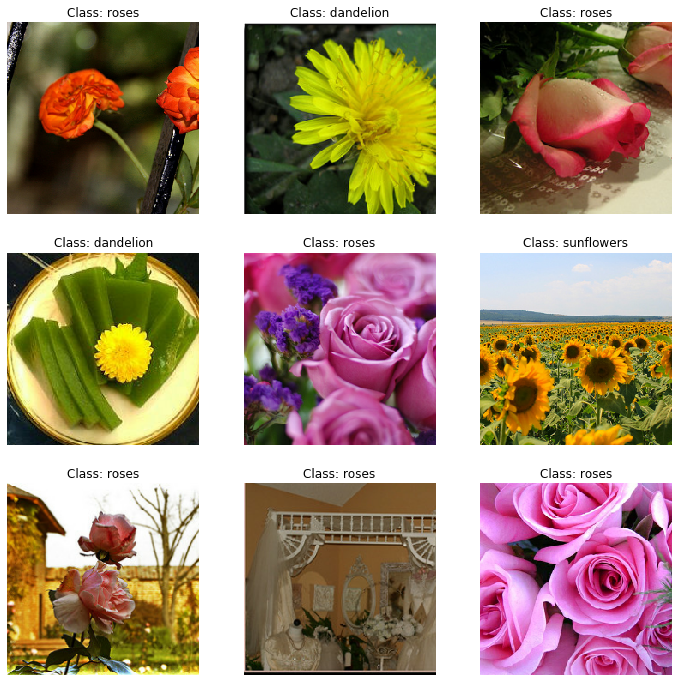

In [49]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

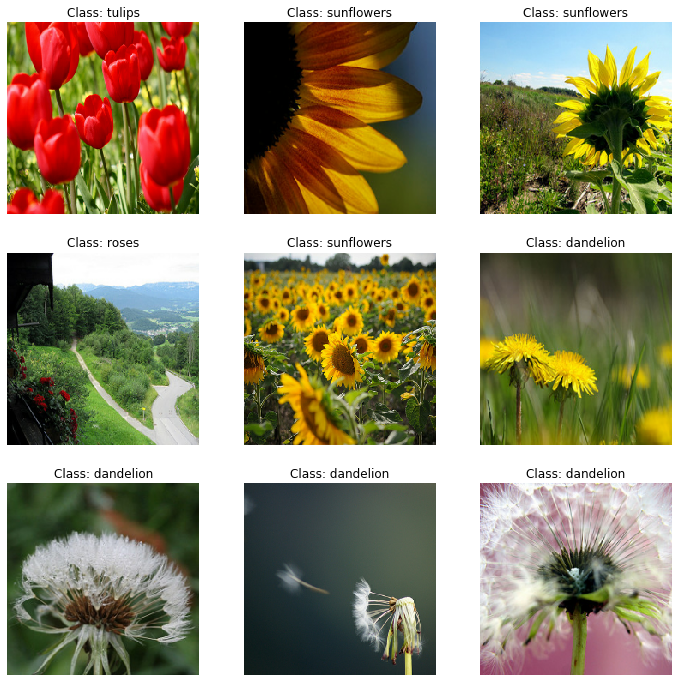

In [50]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [51]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False) # Rachel comment: “include_top” = False -> the output layers of the model are not loaded, allowing a new output layer to be added and trained.
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [52]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_42
13 block2_pool
14 batch_normalization_40
15 add_12
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_43
23 block3_pool
24 batch_normalization_41
25 add_13
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_44
33 block4_pool
34 batch_normalization_42
35 add_14
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_15
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 blo

In [53]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Train for 86 steps, validate for 17 steps
Epoch 1/5
86/86 [==============================] - 73s 846ms/step - loss: 0.7835 - accuracy: 0.7674 - val_loss: 2.2996 - val_accuracy: 0.6746
Epoch 2/5
86/86 [==============================] - 66s 769ms/step - loss: 0.4354 - accuracy: 0.8659 - val_loss: 1.6658 - val_accuracy: 0.7077
Epoch 3/5
86/86 [==============================] - 66s 768ms/step - loss: 0.3298 - accuracy: 0.8866 - val_loss: 1.5356 - val_accuracy: 0.7224
Epoch 4/5
86/86 [==============================] - 67s 774ms/step - loss: 0.2601 - accuracy: 0.9099 - val_loss: 1.4876 - val_accuracy: 0.7243
Epoch 5/5
86/86 [==============================] - 66s 769ms/step - loss: 0.2525 - accuracy: 0.9153 - val_loss: 1.4114 - val_accuracy: 0.7243


In [54]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Train for 86 steps, validate for 17 steps
Epoch 1/40
86/86 [==============================] - 236s 3s/step - loss: 0.2561 - accuracy: 0.9142 - val_loss: 0.4964 - val_accuracy: 0.8732
Epoch 2/40
86/86 [==============================] - 58s 674ms/step - loss: 0.1020 - accuracy: 0.9651 - val_loss: 0.4065 - val_accuracy: 0.8824
Epoch 3/40
86/86 [==============================] - 59s 688ms/step - loss: 0.0512 - accuracy: 0.9829 - val_loss: 0.2959 - val_accuracy: 0.9118
Epoch 4/40
86/86 [==============================] - 64s 742ms/step - loss: 0.0410 - accuracy: 0.9873 - val_loss: 0.3752 - val_accuracy: 0.8971
Epoch 5/40
86/86 [==============================] - 65s 757ms/step - loss: 0.0273 - accuracy: 0.9898 - val_loss: 0.2967 - val_accuracy: 0.9154
Epoch 6/40
86/86 [==============================] - 66s 772ms/step - loss: 0.0224 - accuracy: 0.9924 - val_loss: 0.3110 - val_accuracy: 0.9246
Epoch 7/40
86/86 [==============================] - 65s 754ms/step - loss: 0.0252 - accuracy: 0.9935 -

# Exercises

## 1. High Accuracy CNN for MNIST
_Exercise: Build your own CNN from scratch and try to achieve the highest possible accuracy on MNIST._

The following model uses 2 convolutional layers, followed by 1 pooling layer, then dropout 25%, then a dense layer, another dropout layer but with 50% dropout, and finally the output layer. It reaches about 99.2% accuracy on the test set. This places this model roughly in the top 20% in the [MNIST Kaggle competition](https://www.kaggle.com/c/digit-recognizer/) (if we ignore the models with an accuracy greater than 99.79% which were most likely trained on the test set, as explained by Chris Deotte in [this post](https://www.kaggle.com/c/digit-recognizer/discussion/61480)). Can you do better? To reach 99.5 to 99.7% accuracy on the test set, you need to add image augmentation, batch norm, use a learning schedule such as 1-cycle, and possibly create an ensemble.

In [7]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 12s 226us/sample - loss: 0.1876 - accuracy: 0.9426 - val_loss: 0.0454 - val_accuracy: 0.9882
Epoch 2/10
55000/55000 [==============================] - 9s 167us/sample - loss: 0.0823 - accuracy: 0.9752 - val_loss: 0.0389 - val_accuracy: 0.9908
Epoch 3/10
55000/55000 [==============================] - 9s 165us/sample - loss: 0.0602 - accuracy: 0.9823 - val_loss: 0.0326 - val_accuracy: 0.9902
Epoch 4/10
55000/55000 [==============================] - 9s 169us/sample - loss: 0.0489 - accuracy: 0.9853 - val_loss: 0.0347 - val_accuracy: 0.9908
Epoch 5/10
55000/55000 [==============================] - 9s 166us/sample - loss: 0.0412 - accuracy: 0.9872 - val_loss: 0.0390 - val_accuracy: 0.9892
Epoch 6/10
55000/55000 [==============================] - 9s 164us/sample - loss: 0.0362 - accuracy: 0.9883 - val_loss: 0.0371 - val_accuracy: 0.9910
Epoch 7/10
55000/55000 [==========================

[0.029323639962889378, 0.993]

In [15]:
# Data augmentation
# some commands

original shape (55000, 28, 28, 1)


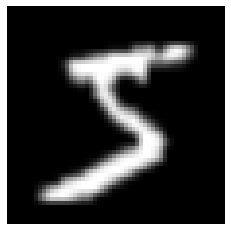

resized shape (55000, 56, 56, 1)


In [8]:
# Data augmentation with tf
# resize

print("original shape", X_train.shape)
imgs = np.asarray(X_train) # type is a NumPy array
imgs_resized = tf.image.resize(imgs, ([56, 56]))

plot_image(imgs_resized[0][:,:,0])
plt.show()
print("resized shape", imgs_resized.shape)


(55000, 56, 56, 1)


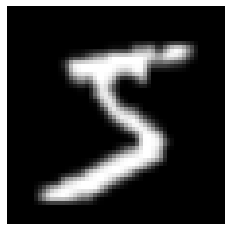

In [9]:
# Data augmentation with tf
# resize

imgs_resized_pad = tf.image.resize_with_pad(imgs, 56, 56, antialias=True)
print (imgs_resized_pad.shape)
plot_image(imgs_resized_pad[0][:,:,0])
plt.show()

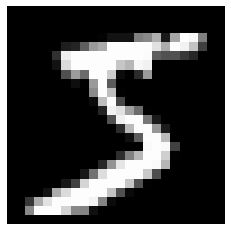

In [10]:
# Data augmentation with tf
# crop centered
imgs_cropped_central = tf.image.central_crop(imgs, central_fraction=0.85)
plot_image(imgs_cropped_central[0][:,:,0])

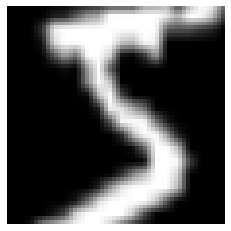

In [11]:
imgs_crop_resized = tf.image.crop_and_resize(imgs, boxes=[[0.2, 0.15, 0.8, 0.85]], box_indices=[0], crop_size=[56, 56])
plot_image(imgs_crop_resized[0][:,:,0])
plt.show()

**Model with image augmentation, batch norm, use a learning schedule such as 1-cycle, and possibly create an ensemble.**

Data augmentation with ImageDataGenerator

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

Model including batch norm:

In [49]:
model = Sequential([
    Conv2D(32, kernel_size=3, padding="same", activation="relu"), 
    BatchNormalization(),
    Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    BatchNormalization(),
    MaxPool2D(),
    Flatten(),
    Dropout(0.25),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 12s 226us/sample - loss: 0.1621 - accuracy: 0.9520 - val_loss: 0.0663 - val_accuracy: 0.9824
Epoch 2/10
55000/55000 [==============================] - 11s 202us/sample - loss: 0.0764 - accuracy: 0.9767 - val_loss: 0.0557 - val_accuracy: 0.9864
Epoch 3/10
55000/55000 [==============================] - 11s 204us/sample - loss: 0.0634 - accuracy: 0.9802 - val_loss: 0.0329 - val_accuracy: 0.9916
Epoch 4/10
55000/55000 [==============================] - 11s 205us/sample - loss: 0.0494 - accuracy: 0.9846 - val_loss: 0.0382 - val_accuracy: 0.9896
Epoch 5/10
55000/55000 [==============================] - 11s 203us/sample - loss: 0.0425 - accuracy: 0.9865 - val_loss: 0.0317 - val_accuracy: 0.9902
Epoch 6/10
55000/55000 [==============================] - 11s 204us/sample - loss: 0.0361 - accuracy: 0.9880 - val_loss: 0.0359 - val_accuracy: 0.9892
Epoch 7/10
55000/55000 [=====================

[0.031770649253827284, 0.9907]

Model including batch norm and Learning schedule such as 1-cycle:

What is One Cycle Learning Rate
It is the combination of gradually increasing learning rate, and optionally, gradually decreasing the momentum during the first half of the cycle, then gradually decreasing the learning rate and optionally increasing the momentum during the latter half of the cycle.

Finally, in a certain percentage of the end of the cycle, the learning rate is sharply reduced every epoch.

'''import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os, sys
os.environ['KMP_DUPLICATE_LIB_OK']='True'
lib_path = os.path.abspath("..")
sys.path.append(lib_path)

import keras_one_cycle_clr as ktool'''

'''model = Sequential([
    Conv2D(32, kernel_size=3, padding="same", activation="relu"), #input_shape=(28, 28, 1)
    BatchNormalization(),
    Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    BatchNormalization(),
    MaxPool2D(),
    Flatten(),
    Dropout(0.25),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation="softmax")
])

ocp = ktool.OneCycle(lr_range=(0.001, 0.01),
                    momentum_range=(0.95, 0.85),
                    verbose=False)

ocp_hist = model.fit(x_train, y_train,
                     epochs=10,
                     validation_data=(X_valid, y_valid),
                     verbose=2,
                     callbacks=[ocp])

model.evaluate(X_test, y_test)

ktool.utils.plot_from_history(ocp_hist)'''

In [6]:
'''# import tensorflow_addons as tfa
# from tfa.optimizers import CyclicalLearningRate'''

'# import tensorflow_addons as tfa\n# from tfa.optimizers import CyclicalLearningRate'

Reduce learning rate when a metric has stopped improving.

Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

In [10]:
# LR Reduction Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=0, factor=0.5, min_lr=0.00001)

Ensemble Of Convolutional Neural Networks
In the next step, we will define 10 CNN models compatible with our data set.

In [79]:
# Define 10 CNN models
from keras.optimizers import RMSprop, Adam
from keras.layers import DepthwiseConv2D, Reshape, Activation

nets = 10
model = [0] *nets

for j in range(nets):
    model[j] = Sequential()
    #First Layer
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    #Second Layer
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    #Third layer
    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))

    #Output layer
    model[j].add(Dense(10, activation='softmax'))

    # Compile each model
    model[j].compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

    
print('All Models Defined')


All Models Defined


In [80]:
#LR Reduction Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=0, factor=0.5, min_lr=0.00001)

In [ ]:

from sklearn.model_selection import train_test_split, KFold
# train for 10 epochs
history = [0] * nets
epochs = 10

datagen.fit(X_train)

for j in range(nets):
    print(f'Individual Net : {j+1}')   
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, y_train, test_size = 0.1)
    history[j] = model[j].fit_generator(datagen.flow(X_train2,Y_train2, batch_size=64), epochs = epochs, steps_per_epoch = X_train2.shape[0]//64, validation_data = (X_val2,Y_val2), callbacks=[learning_rate_reduction], verbose=0)

    print("CNN Model {0:d}: Epochs={1:d}, Training accuracy={2:.5f}, Validation accuracy={3:.5f}".format(j+1,epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))


Individual Net : 1
CNN Model 1: Epochs=10, Training accuracy=0.98750, Validation accuracy=0.99491
Individual Net : 2
CNN Model 2: Epochs=10, Training accuracy=0.98807, Validation accuracy=0.99327
Individual Net : 3
CNN Model 3: Epochs=10, Training accuracy=0.98570, Validation accuracy=0.99400
Individual Net : 4
CNN Model 4: Epochs=10, Training accuracy=0.98655, Validation accuracy=0.99491
Individual Net : 5
CNN Model 5: Epochs=10, Training accuracy=0.98487, Validation accuracy=0.99273
Individual Net : 6
CNN Model 6: Epochs=10, Training accuracy=0.98448, Validation accuracy=0.99236
Individual Net : 7


## 2.  Use transfer learning for large image classification

_Exercise: Use transfer learning for large image classification, going through these steps:_

* _Create a training set containing at least 100 images per class. For example, you could classify your own pictures based on the location (beach, mountain, city, etc.), or alternatively you can use an existing dataset (e.g., from TensorFlow Datasets)._
* _Split it into a training set, a validation set, and a test set._
* _Build the input pipeline, including the appropriate preprocessing operations, and optionally add data augmentation._
* _Fine-tune a pretrained model on this dataset._

See the Flowers example above.

In [ ]:
# Answer in HW3

## 3.
_Exercise: Go through TensorFlow's [Style Transfer tutorial](https://homl.info/styletuto). It is a fun way to generate art using Deep Learning._


https://www.tensorflow.org/tutorials/generative/style_transfer

Simply open the Colab and follow its instructions.

Comments Rachel:

We can summarize some of these usage patterns as follows:

Classifier: The pre-trained model is used directly to classify new images.
Standalone Feature Extractor: The pre-trained model, or some portion of the model, is used to pre-process images and extract relevant features.
Integrated Feature Extractor: The pre-trained model, or some portion of the model, is integrated into a new model, but layers of the pre-trained model are frozen during training.
Weight Initialization: The pre-trained model, or some portion of the model, is integrated into a new model, and the layers of the pre-trained model are trained in concert with the new model.

include_top: Boolean, whether to include the fully-connected layer at the top, as the last layer of the network. Default to True.
weights: One of None (random initialization), imagenet (pre-training on ImageNet), or the path to the weights file to be loaded. Default to imagenet.

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

import tensorflow as tf
print (tf.__version__)
print( tf.config.list_physical_devices())

Another Tensorflow dataset
'''(train_ds, valid_ds, test_ds), ds_info = tfds.load('cats_vs_dogs', split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'], with_info=True, as_supervised=True)

Depend on the tesnsorflow dataset split can be different. split = ['train', 'validation', 'test'], split = ['train', 'test']''' # test or train